## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


Students:

- Juan Manuel Carballo          A01166758
- Paola Estrada Warn            A01795663
- Christopher Flores González   A01795419
- Jorge Pedroza Rivera          A01319553
- Victor Hugo Avila Felipe      A01794425

### Import libraries

In [30]:
# install specific version of pytorch and torchtext because of compatibility issues
# %conda install pytorch==2.3.0 torchtext==0.18.0 torchdata pytorch-cuda=12.1 -c pytorch -c nvidia
# %conda install -c conda-forge portalocker>=2.0.0
# %pip install -U -q numpy
# %pip install matplotlib seaborn
# %pip install -q torchinfo
# %pip install -q scikit-learn

In [31]:
import torch
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.utils.data.dataset as tdataset

import torchtext
torchtext.disable_torchtext_deprecation_warning()

import torchtext.transforms as T

from torchtext.datasets import AG_NEWS
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchinfo import summary

In [32]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        # Allow TensorFloat32 on matmul and convolutions
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.set_float32_matmul_precision("medium")

print(f"Available device: {device.type}")

Available device: cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [33]:
# Download our train and valid data
train_dataset, test_dataset = AG_NEWS(root='../ag_news')
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [34]:
NUM_TRAIN = int(len(train_dataset) * 0.9)
NUM_VALID = len(train_dataset) - NUM_TRAIN

In [35]:
train_dataset, valid_dataset = tdataset.random_split(train_dataset, [NUM_TRAIN, NUM_VALID])

In [36]:
tokenizer_fn = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokenizer_fn(text)
        
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [37]:
MAX_SEQ_LEN = 50
BATCH_SIZE = 64
GLOVE_DIM = 50

In [38]:
class TokenizerTransform(nn.Module):
    
    def __init__(self, tokenizer):
        super(TokenizerTransform, self).__init__()
        self.tokenizer = tokenizer
    
    def forward(self, batch):
        return [ self.tokenizer(line) for line in batch ]

In [39]:
text_transforms = T.Sequential(
    TokenizerTransform(tokenizer=tokenizer_fn),
    T.Truncate(max_seq_len=MAX_SEQ_LEN),
    T.VocabTransform(vocab=vocab),
    T.ToTensor(padding_value=0, dtype=torch.int32),
    T.PadTransform(max_length=MAX_SEQ_LEN, pad_value=0),
)

In [40]:
def collate_batch_fn(batch):
    y, x = list(zip(*batch))
    transformed = text_transforms(list(x))
    return transformed, torch.tensor(y, dtype=torch.int32) - 1

In [41]:
train_loader = tdata.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_fn, shuffle=True)
valid_loader = tdata.DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_fn, shuffle=True)
test_loader = tdata.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_fn, shuffle=True)

In [42]:
for x, _ in train_loader:
    print(x.shape)
    break

torch.Size([64, 50])


### Definition of train and validate functions

In [43]:
def get_batch_accuracy(y_pred, y_true, N):
    _, y_hat = torch.max(y_pred, dim=1)
    correct = torch.sum(y_hat == y_true)
    acc = correct / N
    return acc

In [44]:
def train(model, optimizer, loss_function, dataloader, train_N):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [45]:
def validate(model, loss_function, dataloader, valid_N):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### First Model

In [46]:
class ConvNewsNet(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(ConvNewsNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
            nn.Flatten(start_dim=2),
            nn.Conv1d(50, 100, kernel_size=5, padding=2),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(5),            
            nn.Conv1d(100, 200, kernel_size=5, padding=2),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(5),
            nn.Conv1d(200, 400, kernel_size=5, padding=2),
            nn.BatchNorm1d(400),
            nn.ReLU(inplace=True),
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(400, 4)
        )

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = F.avg_pool1d(x, kernel_size=2)
        x = self.linear(x)
        return x

Define optimizer and loss function

In [47]:
conv_model = ConvNewsNet(vocab_size=len(vocab), embedding_dim=GLOVE_DIM).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(conv_model.parameters())

input_data, _ = next(iter(train_loader))

summary(conv_model, input_data=input_data.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNewsNet                              [64, 4]                   --
├─Sequential: 1-1                        [64, 400, 2]              --
│    └─Embedding: 2-1                    [64, 50, 50]              4,562,250
│    └─Flatten: 2-2                      [64, 50, 50]              --
│    └─Conv1d: 2-3                       [64, 100, 50]             25,100
│    └─BatchNorm1d: 2-4                  [64, 100, 50]             200
│    └─ReLU: 2-5                         [64, 100, 50]             --
│    └─MaxPool1d: 2-6                    [64, 100, 10]             --
│    └─Conv1d: 2-7                       [64, 200, 10]             100,200
│    └─BatchNorm1d: 2-8                  [64, 200, 10]             400
│    └─ReLU: 2-9                         [64, 200, 10]             --
│    └─MaxPool1d: 2-10                   [64, 200, 2]              --
│    └─Conv1d: 2-11                      [64, 400, 2]              

Train the conv model

In [48]:
epochs = 5

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch + 1))
    train(conv_model, optimizer, loss_function, train_loader, len(train_dataset))
    validate(conv_model, loss_function, valid_loader, len(valid_dataset))

Epoch: 1
Train - Loss: 689.8310 Accuracy: 0.8585
Valid - Loss: 49.8726 Accuracy: 0.9095
Epoch: 2
Train - Loss: 335.3604 Accuracy: 0.9328
Valid - Loss: 48.4161 Accuracy: 0.9163
Epoch: 3
Train - Loss: 232.9245 Accuracy: 0.9533
Valid - Loss: 48.3482 Accuracy: 0.9194
Epoch: 4
Train - Loss: 146.9540 Accuracy: 0.9705
Valid - Loss: 57.4902 Accuracy: 0.9123
Epoch: 5
Train - Loss: 77.1694 Accuracy: 0.9847
Valid - Loss: 74.7559 Accuracy: 0.9055


### Second model

In [49]:
class RNNNewsNet(nn.Module):
    
    def __init__(self, embedding_dim, hidden_size):
        super(RNNNewsNet, self).__init__()
        
        self.rnn1 = nn.Sequential(
            nn.Embedding.from_pretrained(GloVe(name="6B", dim=embedding_dim, cache='../embeddings').vectors),
            nn.LSTM(embedding_dim, hidden_size=hidden_size, num_layers=3, batch_first=True),
        )
        
        self.dropout = nn.Dropout(p=.2)
        
        self.rnn2 = nn.Sequential(
            nn.AvgPool1d(2),
            nn.LSTM(embedding_dim//2, hidden_size=hidden_size//2, num_layers=2, batch_first=True),
        )
        
        self.rnn3 = nn.Sequential(
            nn.AvgPool1d(5),
            nn.LSTM((embedding_dim//2)//5, hidden_size=(hidden_size//2)//5, num_layers=1, batch_first=True),
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(250, 4),
        )
        
    def forward(self, input):
        x = input
        x, _ = self.rnn1(x)
        x = self.dropout(x)
        x, _ = self.rnn2(x)
        x = self.dropout(x)
        x, _ = self.rnn3(x)
        x = self.fc(x)
        return x

In [50]:
rnn_model = RNNNewsNet(embedding_dim=GLOVE_DIM, hidden_size=50).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters())

input_data, _ = next(iter(train_loader))

summary(rnn_model, input_data=input_data.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
RNNNewsNet                               [64, 4]                   --
├─Sequential: 1-1                        [64, 50, 50]              --
│    └─Embedding: 2-1                    [64, 50, 50]              (20,000,000)
│    └─LSTM: 2-2                         [64, 50, 50]              61,200
├─Dropout: 1-2                           [64, 50, 50]              --
├─Sequential: 1-3                        [64, 50, 25]              --
│    └─AvgPool1d: 2-3                    [64, 50, 25]              --
│    └─LSTM: 2-4                         [64, 50, 25]              10,400
├─Dropout: 1-4                           [64, 50, 25]              --
├─Sequential: 1-5                        [64, 50, 5]               --
│    └─AvgPool1d: 2-5                    [64, 50, 5]               --
│    └─LSTM: 2-6                         [64, 50, 5]               240
├─Sequential: 1-6                        [64, 4]                  

In [51]:
epochs = 15

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch + 1))
    train(rnn_model, optimizer, loss_function, train_loader, len(train_dataset))
    validate(rnn_model, loss_function, valid_loader, len(valid_dataset))

Epoch: 1
Train - Loss: 1968.9503 Accuracy: 0.4556
Valid - Loss: 174.2271 Accuracy: 0.6217
Epoch: 2
Train - Loss: 1311.0896 Accuracy: 0.6896
Valid - Loss: 124.7922 Accuracy: 0.7490
Epoch: 3
Train - Loss: 1037.4599 Accuracy: 0.7665
Valid - Loss: 106.6569 Accuracy: 0.7873
Epoch: 4
Train - Loss: 888.3265 Accuracy: 0.8031
Valid - Loss: 93.4929 Accuracy: 0.8148
Epoch: 5
Train - Loss: 791.6745 Accuracy: 0.8263
Valid - Loss: 98.7543 Accuracy: 0.8075
Epoch: 6
Train - Loss: 728.0432 Accuracy: 0.8430
Valid - Loss: 83.3053 Accuracy: 0.8400
Epoch: 7
Train - Loss: 672.1311 Accuracy: 0.8558
Valid - Loss: 85.9603 Accuracy: 0.8407
Epoch: 8
Train - Loss: 630.1495 Accuracy: 0.8653
Valid - Loss: 77.9663 Accuracy: 0.8527
Epoch: 9
Train - Loss: 592.1544 Accuracy: 0.8733
Valid - Loss: 83.1498 Accuracy: 0.8421
Epoch: 10
Train - Loss: 558.8562 Accuracy: 0.8813
Valid - Loss: 73.7994 Accuracy: 0.8623
Epoch: 11
Train - Loss: 529.3749 Accuracy: 0.8882
Valid - Loss: 71.9717 Accuracy: 0.8668
Epoch: 12
Train - Loss: 

### Test the Model

In [52]:
print("CNN Model: ", end="")
validate(conv_model, loss_function, test_loader, len(test_dataset))

print("RNN Model: ", end="")
validate(rnn_model, loss_function, test_loader, len(test_dataset))

CNN Model: Valid - Loss: 50.2047 Accuracy: 0.9013
RNN Model: Valid - Loss: 44.8392 Accuracy: 0.8675


### Confusion Matrix

In [53]:
y_pred1 = []
y_pred2 = []

y_true = []

for inputs, labels in test_loader:
    output1 = conv_model(inputs.to(device))
    output2 = rnn_model(inputs.to(device))
    
    output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
    output2 = (torch.max(torch.exp(output2), 1)[1]).data.cpu().numpy()
    
    y_pred1.extend(output1)
    y_pred2.extend(output2)
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)


labels =  ["World", "Sports", "Business", "Sci/Tech"]

#### Confusion Matrix for Convolutional Network

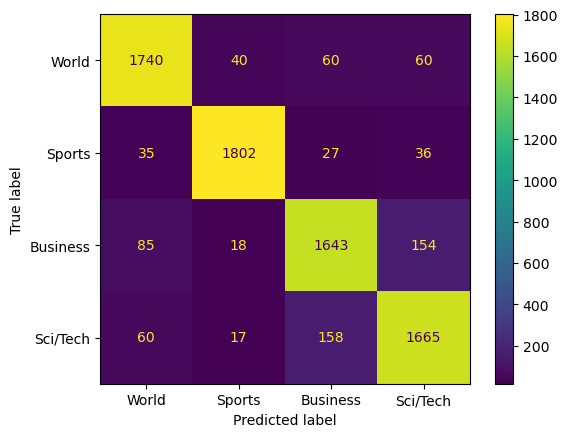

In [54]:
cf_matrix1 = confusion_matrix(y_true=y_true, y_pred=y_pred1)

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix1, display_labels=labels)
disp.plot()

#### Confusion Matrix for Recurrent Network

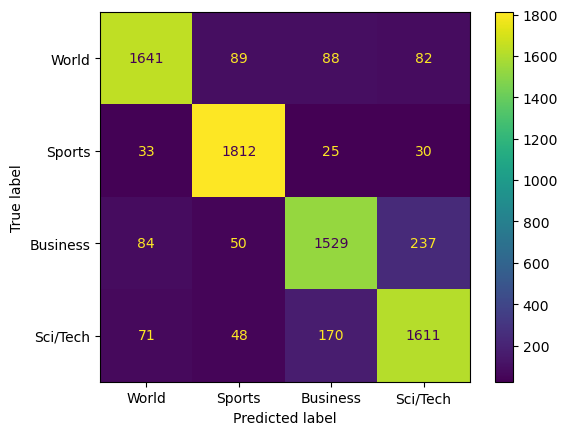

In [55]:
cf_matrix2 = confusion_matrix(y_true=y_true, y_pred=y_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix2, display_labels=labels)
disp.plot()

### Text Sampling Function

Four real news from an online web page correspond to the headers of articles in the sections World, Sports, Business and Tech.

In [56]:
news = [
    # Business
    "Trump said he would set a tariff of 25 percent on the country’s largest trading partner if it didn’t close the border, ratcheting up as high as 100 if that didn’t work.",
    # Sports
    "Milwaukee superstar Giannis Antetokounmpo will miss Monday night’s game against the unbeaten Cleveland Cavaliers with a strained adductor muscle, another early-season hiccup for the struggling Bucks",
    # Tech
    "There’s a simple and effective new way to deep clean your privacy and security on Facebook, Google, X and more, from a startup called Block Party.",
    # World
    "Officials say proxies working for Russia were likely behind bombs destined for DHL flights in Europe, and U.S.-bound planes may have been a future target.",
]

In [57]:
def text_sampling(text_lines):
    tensors = text_transforms(text_lines)
    tensors = tensors.to(device)    
    logits = rnn_model(tensors)
    _, classes = torch.max(logits, dim=1)
    results = []
    for clazz in classes:
        results.append(labels[clazz])
    return results

In [58]:
text_sampling(news)

['Business', 'Sports', 'Sci/Tech', 'World']